In [1]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
from tensorflow import keras
import numpy as np, matplotlib.pyplot as plt
from os.path import join

Autosaving every 120 seconds


### define model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters, use_bias=1, kernel_initializer='he_normal', **conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=1,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) #32
    spatial_layer(2,6) #64
    spatial_layer(2,9) #96
    
    
    model.add(Flatten())
    dense_bn_relu(30) #96
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 79, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 79, 79, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 77, 77, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 32)        9

### train

In [3]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h= 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {}'.format(labels2name[predictions[idx]])
        ax.flatten()[i].set_title(title)

In [4]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
root = r'C:\Users\rochela\Documents\school\bootcamp\projects\mobileye_project\data_lib'
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }

#prepare our model
m = tfl_model()
m.compile(optimizer=keras.optimizers.Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
history = m.fit(train['images'], train['labels'], validation_data=(val['images'],val['labels']), epochs=10)

Train on 3316 samples, validate on 582 samples
Epoch 1/10
3316/3316 [==============================] - 115s 35ms/sample - loss: 0.6050 - accuracy: 0.6900 - val_loss: 0.6193 - val_accuracy: 0.6770
Epoch 2/10
3316/3316 [==============================] - 109s 33ms/sample - loss: 0.4476 - accuracy: 0.8004 - val_loss: 0.4282 - val_accuracy: 0.7973
Epoch 3/10
3316/3316 [==============================] - 101s 30ms/sample - loss: 0.4095 - accuracy: 0.8148 - val_loss: 0.4612 - val_accuracy: 0.7921
Epoch 4/10
3316/3316 [==============================] - 91s 27ms/sample - loss: 0.3703 - accuracy: 0.8399 - val_loss: 0.4229 - val_accuracy: 0.7921
Epoch 5/10
3316/3316 [==============================] - 90s 27ms/sample - loss: 0.3686 - accuracy: 0.8387 - val_loss: 0.3850 - val_accuracy: 0.8230
Epoch 6/10
3316/3316 [==============================] - 92s 28ms/sample - loss: 0.3370 - accuracy: 0.8519 - val_loss: 0.4581 - val_accuracy: 0.8024
Epoch 7/10
3316/3316 [==============================] - 92s 28

In [6]:
m.save('my_model.h5')

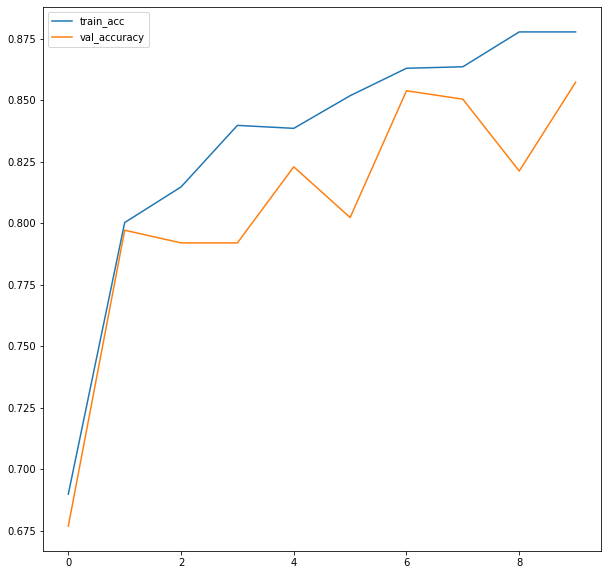

In [10]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_acc'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

### evaluate and predict

accuracy: 0.8573883161512027


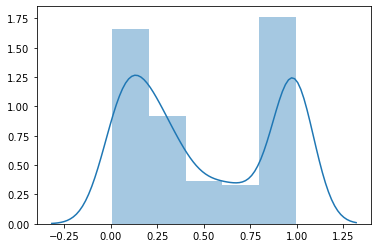

In [17]:
import seaborn as sbn
predictions = m.predict(np.array(val['images'], dtype='float32'))
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

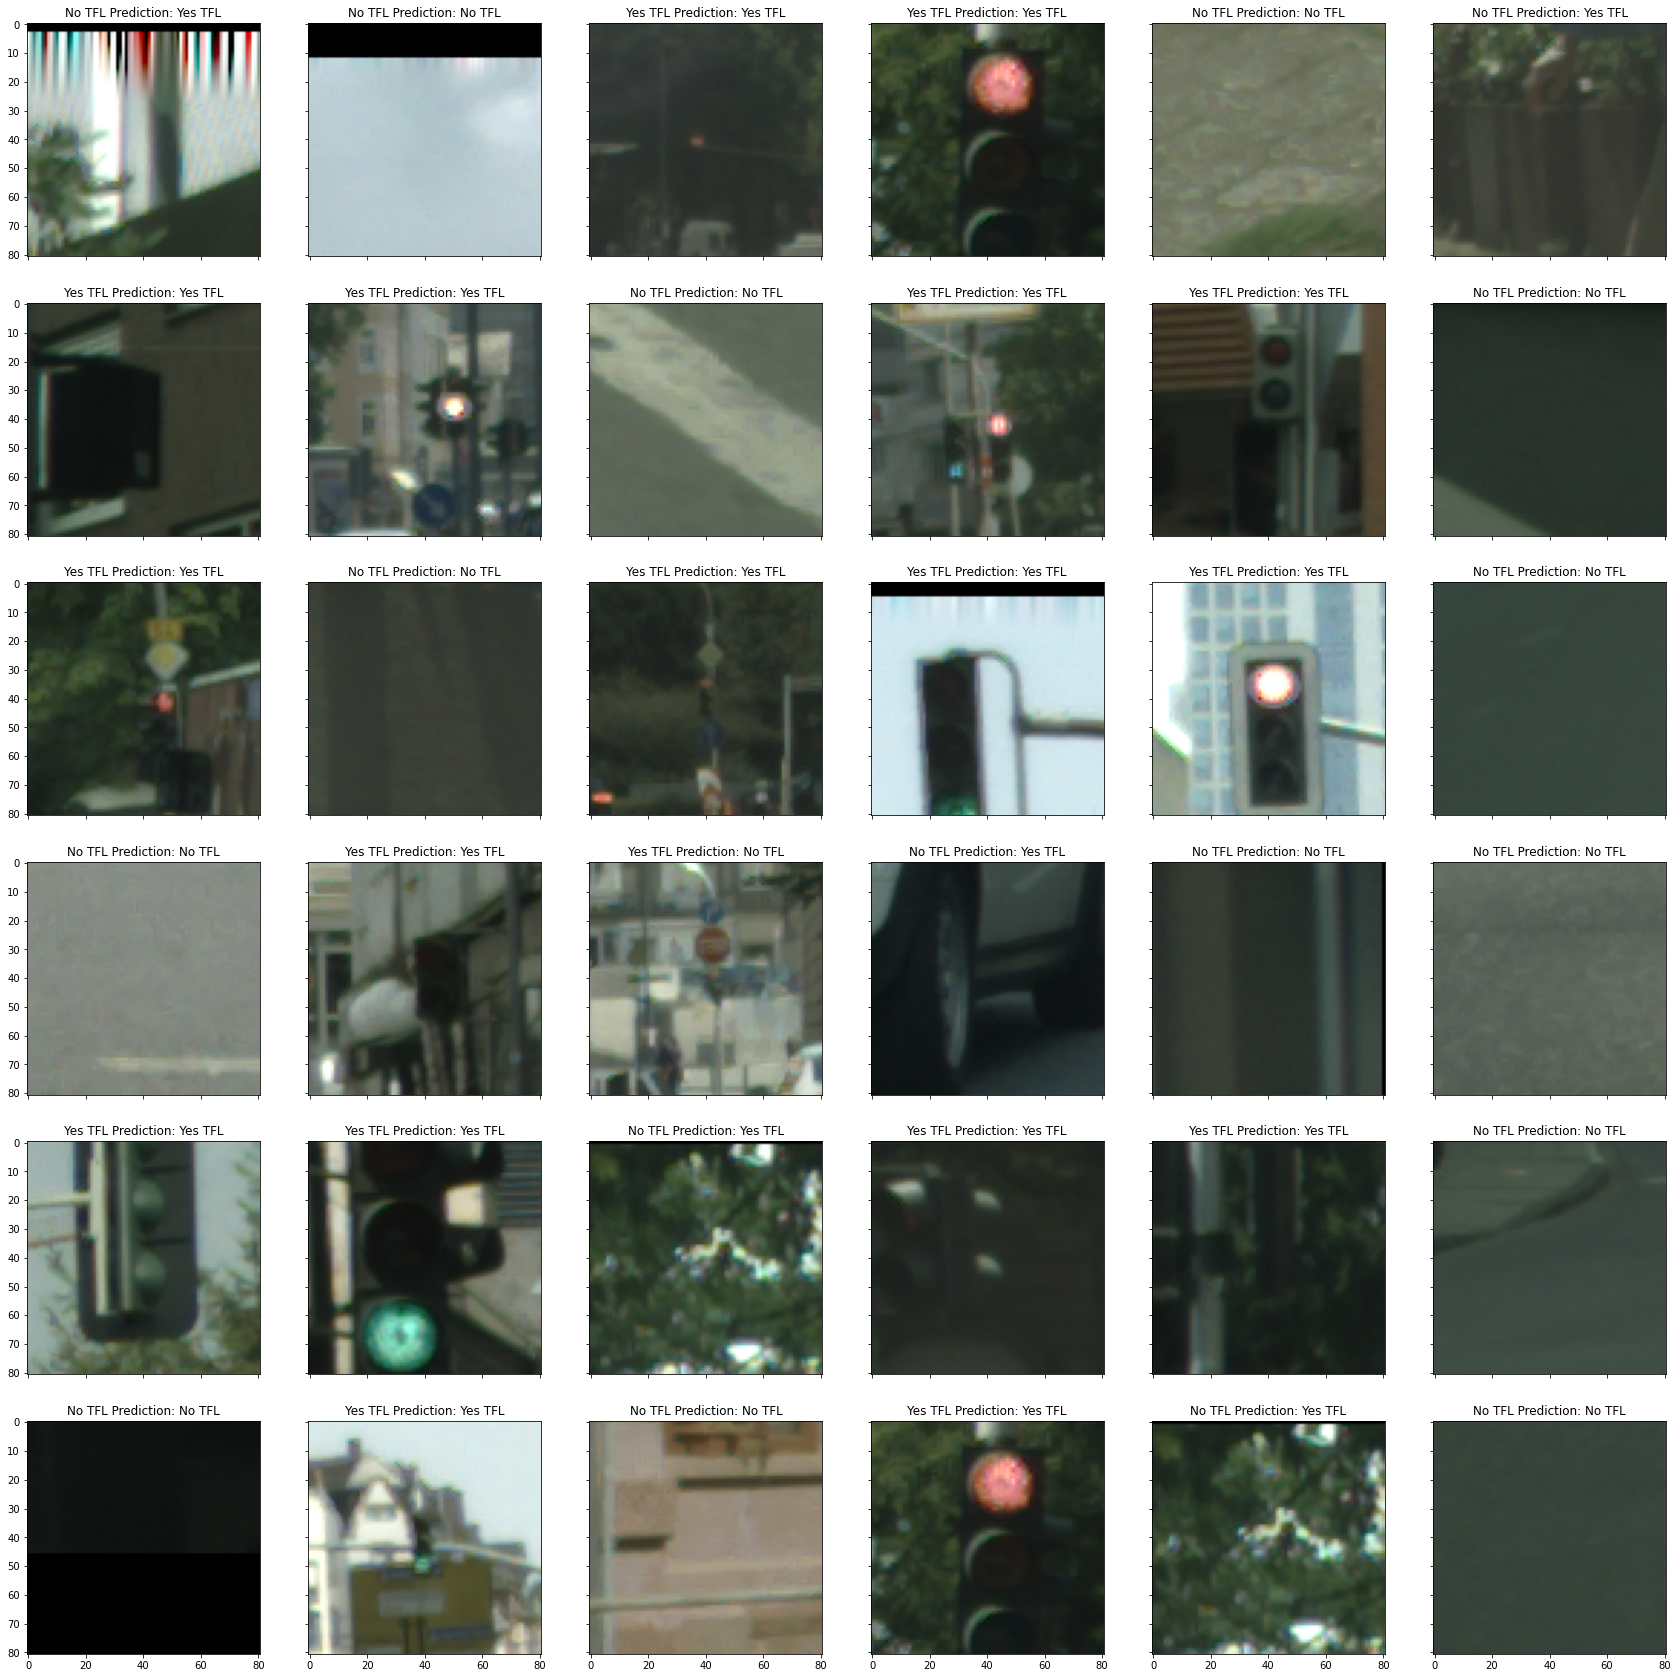

In [18]:
viz_my_data(num=(6,6),predictions=predicted_label,**val);